### This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on MNIST data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

This cell loads the data and normalizes it to the [0,1] range

In [8]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

mat = scipy.io.loadmat('mnist_all.mat')

Nc=10 # output nodes
N=784 # number of pixels for each image. 28x28
Ns=60000 # 60000 training and validation examples. Number of samples
M=np.zeros((0,N))

for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

# M now contains the 784 pixel values for each of the 60000 images.
# M.shape = (60000, 784)

To draw a heatmap of the weights a helper function is created:

In [9]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   
    

This cell defines paramaters of the algorithm: `eps0` - initial learning rate that is linearly annealed during training; `hid` - number of hidden units that are displayed as an `Ky` by `Kx` array by the helper function defined above; `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the minibatch; `prec` - parameter that controls numerical precision of the weight updates; `delta` - the strength of the anti-hebbian learning; `p` - Lebesgue norm of the weights; `k` - ranking parameter. 

In [10]:
eps0=2e-2    # learning rate
Kx=10
Ky=10
hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
mu=0.0
sigma=1.0
Nep=200      # number of epochs
Num=100      # size of the minibatch
prec=1e-30
delta=0.4    # Strength of the anti-hebbian learning
p=2.0        # Lebesgue norm of the weights
k=2          # ranking parameter, must be integer that is bigger or equal than 2

# These last 3 values are proved to be different in the paper. 
# In the paper, for MNIST, the best combination was
# p=3, k=7, delta =0.4

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

<IPython.core.display.Javascript object>


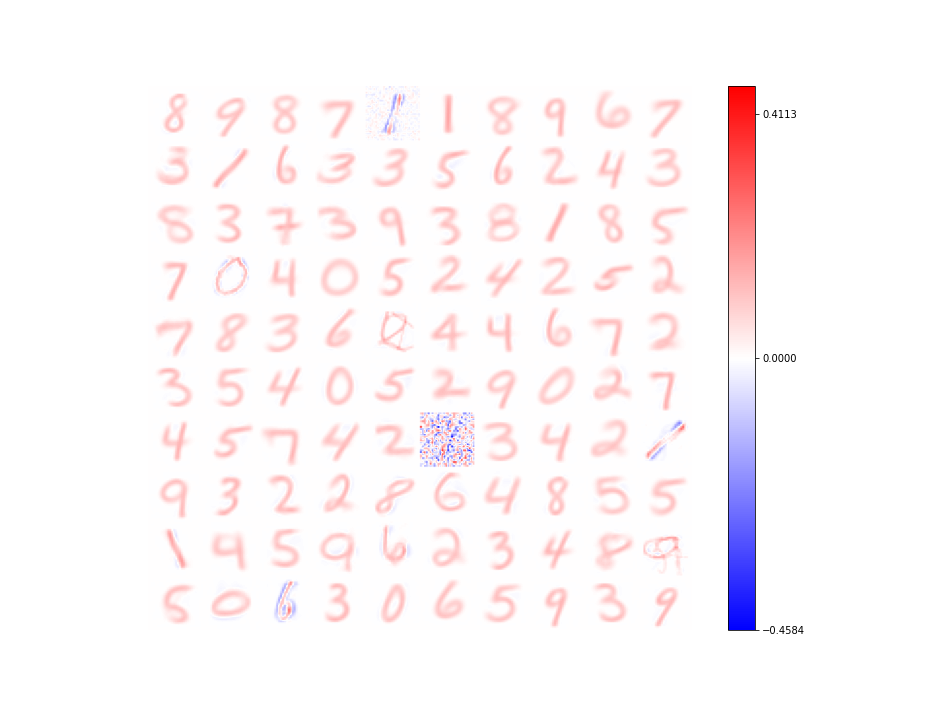

200
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch:

In [4]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

synapses = np.random.normal(mu, sigma, (hid, N))

print(Nep)
for nep in range(Nep):
    print("Epoch:", nep)
    eps=eps0*(1-nep/Nep)
    M=M[np.random.permutation(Ns),:] # Scramble the images and values in M. So that when making a
    # mini batch, random values/images will be chosen on each iteration.
    for i in range(Ns//Num):
        inputs=np.transpose(M[i*Num:(i+1)*Num,:])
        sig=np.sign(synapses)
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
        
        y=np.argsort(tot_input,axis=0)
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta
        
        xx=np.sum(np.multiply(yl,tot_input),1)
        ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)
        
        nc=np.amax(np.absolute(ds))
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)
        
    draw_weights(synapses, Kx, Ky)
        

In [ ]:
import sys
%matplotlib inline
%matplotlib notebook

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(mu)
print(sigma)
print(hid)
print(N)

# Initialize random synapses.
# Question: We are only considering synapses for 100 randomly chosen images?
synapses = np.random.normal(mu, sigma, (hid, N))
print(synapses.shape) # == (100, 784)
print(synapses)


In [ ]:
import sys

%matplotlib inline
%matplotlib notebook

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

synapses = np.random.normal(mu, sigma, (hid, N))

# LEARNING RATE gets annealed or decreased over time according to the epoch.
#     This is shown in the values of 'eps' which change per outer loop.

print("Nep: ", Nep)
print("eps0: ", eps0)
print("Start outer loop through epochs")

for nep in range(Nep):
    
    print("\tnep: ", nep)
    learning_rate_multiplier = (1-nep/Nep)
    print("\tlearning_rate_multiplier = (1-nep/Nep) : ", learning_rate_multiplier)
    
    eps=eps0*(1-nep/Nep)
    
    print("\teps = current learning_rate: ", eps)
    
    # M contains the 784 pixel values for each of the 60000 images.
    # M.shape at the fucking beginning = (60000, 784)
    # What this line does: Scramble the images and values in M. So that when making a
    # mini batch, random values will be chosen on each iteration.
    # The 60,000 vectors with pixel values are now randomized.
    print("\tM.shape before random perm:", M.shape)
    M=M[np.random.permutation(Ns),:] 
    print("\tM.shape after random perm:", M.shape)

    print()

In [ ]:
# FIGURING OUT WHAT tot_input MEANS. IT MEANS THE INPUT CURRENT THAT IS USED IN THE FAST IMPLEMENTATION OF THE ALGO.

import sys

%matplotlib inline
%matplotlib notebook
#fig=plt.figure(figsize=(12.9,10))

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

synapses = np.random.normal(mu, sigma, (hid, N))

print("Start outer loop over epochs")
for nep in range(Nep):
    print("\tStart Epoch:", nep)
    eps=eps0*(1-nep/Nep)
    M=M[np.random.permutation(Ns),:]
    
    print("\tStart inner loop over mini-batches")
    
    # // is division without decimal places. Equivalent to dividing ints in c++ or java.
    num_mini_batches = Ns//Num
    print("\tnum_mini_batches:", num_mini_batches)
    for i in range(Ns//Num):
        print("\t\tstart batch number i:", i)
        
        # ... Do shit ...
        
        # Get batch of 100 images. This is 100 vectors of size 784 pixels in each.
        # Applying Transpose makes the shape 784x100
        inputs=np.transpose(M[i*Num:(i+1)*Num,:])
        print("\t\tinputs.shape:", inputs.shape)
        
        # The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.
        # Returns either scaler or ndarray depending on type passed in.
        sig=np.sign(synapses)
        print("\t\tsynapses.shape:", synapses.shape)
        print("\t\tsig.shape:", sig.shape)
        
        # This corresponds to calculating I (current) in Eq [8]. Also Eq [2 and 6] where abs value of synapses is used
        # Is this calculating Q in equation [3] ?
        # NO NO NO 
        # This is following the fast implementation.
        # Calculating the currents.
        # Using this as a proxy for ranking of the final activities.
        # How is current calculated? Look at right hand side of Eq [8].
        # How is dot product calculated? Look at Eq [2]
        # 
        # For every minibatch the overlap with the data tot_input is calculated 
        # for each data point and each hidden unit. 
        # The sorted strengths of the activations are stored in y.
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
        # TODO: Why (p-1) above and not (p-2) as in the paper?
        # I believe it is To stick with the same requirements as in the paper:
        # "where p ≥1 is the parameter defining the Lebesgue p norm. 
        #  In the case of p =2 this inner product is the conventional dot product between two vectors, 
        #  and if p >2 the contribution of the weights in the metric ηij becomes important."
        # This last line means that the contribution of the weights/synapses becomes very important
        # as defined by the metric ηij in the paper.
        
        print("\t\tend batch number i:", i)
        print()
        
    print("\tFinish inner loop over mini-batches")
    
    print("\tEnd Epoch:", nep)
    print()

In [ ]:
# LOOKING AT Y AND Y_L

import sys

%matplotlib inline
%matplotlib notebook
#fig=plt.figure(figsize=(12.9,10))

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

synapses = np.random.normal(mu, sigma, (hid, N))

print("Start outer loop over epochs")
for nep in range(Nep):
    print("\tStart Epoch:", nep)
    eps=eps0*(1-nep/Nep)
    M=M[np.random.permutation(Ns),:]
    
    print("\tStart inner loop over mini-batches")
    
    # // is division without decimal places. Equivalent to dividing ints in c++ or java.
    num_mini_batches = Ns//Num
    print("\tnum_mini_batches:", num_mini_batches)
    for i in range(Ns//Num):
        print("\t\tstart batch number i:", i)
        
        # ... Do shit ...
        
        # Get batch of 100 images. This is 100 vectors of size 784 pixels in each.
        # Applying Transpose makes the shape 784x100
        inputs=np.transpose(M[i*Num:(i+1)*Num,:])
        print("\t\tinputs.shape:", inputs.shape)
        
        # The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.
        # Returns either scaler or ndarray depending on type passed in.
        sig=np.sign(synapses)
        print("\t\tsynapses.shape:", synapses.shape)
        print("\t\tsig.shape:", sig.shape)
        
        # This corresponds to calculating I (current) in Eq [8]. Also Eq [2 and 6] where abs value of synapses is used
        # Is this calculating Q in equation [3] ?
        # NO
        # This is following the fast implementation.
        # Calculating the currents.
        # Using this as a proxy for ranking of the final activities.
        # How is current calculated? Look at right hand side of Eq [8].
        # How is dot product calculated? Look at Eq [2]
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
        #print("\t\t", tot_input)
        
        # From the paper regarding fast implementation: 
        # "Instead of solving dynamical equations we use the currents as a proxy for ranking of the final activities"
        # "Given that ranking, the unit that responds the most to a given training example is pushed toward 
        # that example with activation g =1."
        # "The unit that is second (or more generally kth) in ranking is pushed away from the training example 
        # with activation g = −delta".
        
        # The sorted strengths of the activations are stored in y. 
        # The variable yl stores the activations of the post synaptic cells - 
        # it is denoted by g(Q) in Eq 3 of Unsupervised Learning by Competing Hidden Units, see also Eq 9 and Eq 10
        
        # The sorted strengths of the activations are stored in y. 
        y=np.argsort(tot_input,axis=0) # argsort Returns the indices that would sort an array.
        
        # The variable yl stores the activations of the post synaptic cells - 
        # it is denoted by g(Q) in Eq 3 of Unsupervised Learning by Competing Hidden Units, see also Eq 9 and Eq 10.
        # Look at Eq [10]
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta
        
        print("\t\tyl.shape:", yl.shape)
        
        print("\t\tend batch number i:", i)
        print()
        
    print("\tFinish inner loop over mini-batches")
    
    print("\tEnd Epoch:", nep)
    print()

In [ ]:
# LOOKING AT XX AND DS

import sys

%matplotlib inline
%matplotlib notebook
#fig=plt.figure(figsize=(12.9,10))

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

synapses = np.random.normal(mu, sigma, (hid, N))

print("Start outer loop over epochs")
for nep in range(Nep):
    print("\tStart Epoch:", nep)
    eps=eps0*(1-nep/Nep)
    M=M[np.random.permutation(Ns),:]
    
    print("\tStart inner loop over mini-batches")
    
    # // is division without decimal places. Equivalent to dividing ints in c++ or java.
    num_mini_batches = Ns//Num
    print("\tnum_mini_batches:", num_mini_batches)
    for i in range(Ns//Num):
        print("\t\tstart batch number i:", i)
        
        # ... Do shit ...
        
        # Get batch of 100 images. This is 100 vectors of size 784 pixels in each.
        # Applying Transpose makes the shape 784x100
        inputs=np.transpose(M[i*Num:(i+1)*Num,:])
        print("\t\tinputs.shape:", inputs.shape)
        
        # The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.
        # Returns either scaler or ndarray depending on type passed in.
        sig=np.sign(synapses)
        print("\t\tsynapses.shape:", synapses.shape)
        print("\t\tsig.shape:", sig.shape)
        
        # This corresponds to calculating I (current) in Eq [8]. Also Eq [2 and 6] where abs value of synapses is used
        # Is this calculating Q in equation [3] ?
        # NO
        # This is following the fast implementation.
        # Calculating the currents.
        # Using this as a proxy for ranking of the final activities.
        # How is current calculated? Look at right hand side of Eq [8].
        # How is dot product calculated? Look at Eq [2]
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
        #print("\t\t", tot_input)
        
        # From the paper regarding fast implementation: 
        # "Instead of solving dynamical equations we use the currents as a proxy for ranking of the final activities"
        # "Given that ranking, the unit that responds the most to a given training example is pushed toward 
        # that example with activation g =1."
        # "The unit that is second (or more generally kth) in ranking is pushed away from the training example 
        # with activation g = −delta".
        
        # The sorted strengths of the activations are stored in y. 
        y=np.argsort(tot_input,axis=0) # argsort Returns the indices that would sort an array.
        
        # The variable yl stores the activations of the post synaptic cells - 
        # it is denoted by g(Q) in Eq 3 of Unsupervised Learning by Competing Hidden Units, see also Eq 9 and Eq 10.
        # Look at Eq [10]
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta
        
        # The variable ds is the right hand side of Eq 3. 
        # The weights are updated after each minibatch in a way so that the largest update is 
        # equal to the learning rate eps at that epoch. 
        # The weights are displayed by the helper function after each epoch.
        
        # The variable ds is the right hand side of Eq 3.
        # xx is equal to multiplying g(Q) by the input current. Then summing across the columns (each element on x-axis)
        # This is partially the 2nd term in right hand side of Eq [3]]
        
        # np.multiply just multiplies element-wise.
        # Multiplies element by element. NOT matrix multiplication.
        # Why use np.multiply and not np.dot ?
        print("\t\tyl.shape:", yl.shape)
        print("\t\ttot_input.shape:", tot_input.shape)
        xx=np.sum(np.multiply(yl,tot_input),1)
        print("\t\txx.shape:", xx.shape)
        print("\t\txx.shape[0]:", xx.shape[0])
        
        # yl.shape: (100, 100)
        # tot_input.shape: (100, 100)
        # xx.shape = (100,)
        # xx.shape[0] = 100
        # xx_reshape = (100, 1)
        # xx_tile = (100, 784)
        
        xx_reshape = xx.reshape(xx.shape[0],1)
        print("\t\txx_reshape.shape:", xx_reshape.shape)
        #print("\t\txx_reshape:", xx_reshape)
        
        # numpy.tile(arr, repetitions) : constructs a new array by repeating array – ‘arr’,
        # the number of times we want to repeat as per repetitions
        xx_tile = np.tile(xx.reshape(xx.shape[0],1),(1,N))
        print("\t\txx_tile.shape:", xx_tile.shape)
        #print("\t\txx_tile:", xx_tile)
        
        tile_something = np.tile(xx.reshape(xx.shape[0],1),(1,N))
        ds_something = np.multiply(tile_something,synapses)
        # Again, why np.multiply and not matmul ?? Why do element wise multiplication and not matrix multiplication?
        # Is it the same thing?
        
        ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)
        print("\t\tds.shape:", ds.shape)
        
        nc=np.amax(np.absolute(ds))
        print("\t\tnc:", nc)
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)
        # true divide to normalise. Then update synapses
        
        print("\t\tend batch number i:", i)
        print()
        
    print("\tFinish inner loop over mini-batches")
    
    draw_weights(synapses, Kx, Ky)
    
    print("\tEnd Epoch:", nep)
    print()

This cell defines the main code. The external loop runs over epochs nep, the internal loop runs over minibatches. For every minibatch the overlap with the data tot_input is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in y. The variable yl stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of Unsupervised Learning by Competing Hidden Units, see also Eq 9 and Eq 10. The variable ds is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate eps at that epoch. The weights are displayed by the helper function after each epoch.

In [ ]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

synapses = np.random.normal(mu, sigma, (hid, N))

print(Nep)
for nep in range(Nep):
    print("Epoch:", nep)
    eps=eps0*(1-nep/Nep)
    M=M[np.random.permutation(Ns),:] # Scramble the images and values in M. So that when making a
    # mini batch, random values/images will be chosen on each iteration.
    for i in range(Ns//Num):
        inputs=np.transpose(M[i*Num:(i+1)*Num,:])
        sig=np.sign(synapses)
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
        
        y=np.argsort(tot_input,axis=0)
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta
        
        xx=np.sum(np.multiply(yl,tot_input),1)
        ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)
        
        nc=np.amax(np.absolute(ds))
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)
        
    draw_weights(synapses, Kx, Ky)